In [1]:
# Download dataset from UCI
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

# Unzip the file
!unzip -o smsspamcollection.zip

--2026-02-20 14:25:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  --.-KB/s    in 0.1s    

2026-02-20 14:25:18 (1.32 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [2]:
import pandas as pd

# Load dataset (tab-separated file)
data = pd.read_csv("SMSSpamCollection", sep='\t', header=None)

# Rename columns
data.columns = ['label', 'message']

# Display first 5 rows
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print("Dataset Shape:", data.shape)
print("\nLabel Distribution:")
print(data['label'].value_counts())

Dataset Shape: (5572, 2)

Label Distribution:
label
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
# Convert labels to numeric
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

data.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data['message'],
    data['label'],
    test_size=0.2,
    random_state=42
)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Number of features:", X_train_tfidf.shape[1])

Number of features: 7441


In [7]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [8]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.97847533632287

Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [9]:
def predict_spam(message):
    message_tfidf = vectorizer.transform([message])
    prediction = model.predict(message_tfidf)

    if prediction[0] == 1:
        return "Spam"
    else:
        return "Ham"

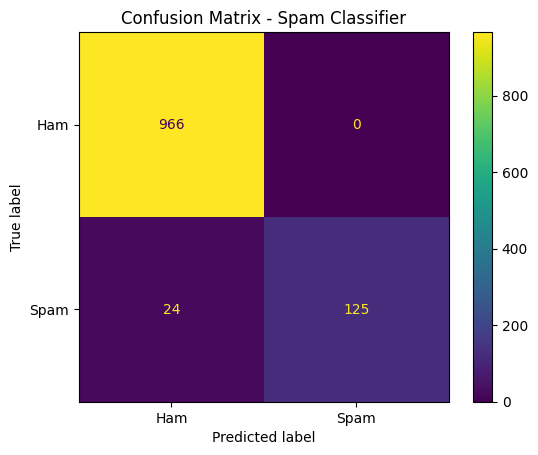

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot()

plt.title("Confusion Matrix - Spam Classifier")
plt.show()

In [12]:
import numpy as np

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get log probabilities for spam class (class index 1)
spam_log_probs = model.feature_log_prob_[1]

# Get top 20 spam words
top_spam_indices = np.argsort(spam_log_probs)[-20:]
top_spam_words = feature_names[top_spam_indices]

print("Top 20 Spam-Indicative Words:\n")
for word in reversed(top_spam_words):
    print(word)

Top 20 Spam-Indicative Words:

free
txt
mobile
text
claim
stop
reply
ur
www
prize
cash
new
won
uk
urgent
win
150p
nokia
service
send


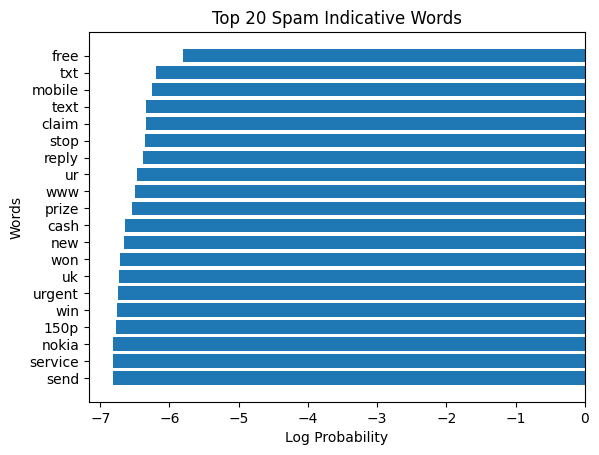

In [13]:
top_spam_probs = spam_log_probs[top_spam_indices]

plt.figure()
plt.barh(top_spam_words, top_spam_probs)
plt.title("Top 20 Spam Indicative Words")
plt.xlabel("Log Probability")
plt.ylabel("Words")
plt.show()

In [30]:
# Example: Get probability for test set
y_prob = model.predict_proba(X_test_tfidf)

print(y_prob[:5])   # Shows probability for Ham and Spam

[[0.9516521  0.0483479 ]
 [0.9607589  0.0392411 ]
 [0.98635654 0.01364346]
 [0.99457221 0.00542779]
 [0.85945018 0.14054982]]


In [31]:
def predict_spam_with_probability(message):
    message_tfidf = vectorizer.transform([message])

    prediction = model.predict(message_tfidf)[0]
    probabilities = model.predict_proba(message_tfidf)[0]

    spam_prob = probabilities[1]
    ham_prob = probabilities[0]

    if prediction == 1:
        print(f"🚨 Spam (Confidence: {spam_prob*100:.2f}%)")
    else:
        print(f"✅ Ham (Confidence: {ham_prob*100:.2f}%)")

In [32]:
predict_spam_with_probability("Congratulations! You have won a free iPhone")
predict_spam_with_probability("Hey bro, are we meeting tomorrow?")

🚨 Spam (Confidence: 65.87%)
✅ Ham (Confidence: 99.17%)


In [33]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [34]:
y_prob_nb = model.predict_proba(X_test_tfidf)[:, 1]

In [35]:
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_prob_nb)
auc_nb = roc_auc_score(y_test, y_prob_nb)

print("Naive Bayes AUC:", auc_nb)

Naive Bayes AUC: 0.982707351980769


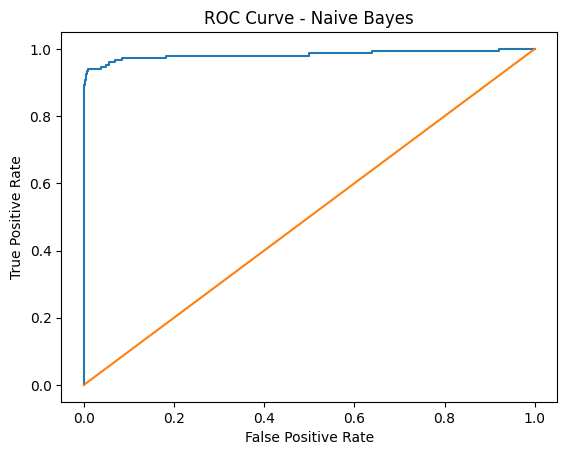

In [36]:
plt.figure()
plt.plot(fpr_nb, tpr_nb)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.show()

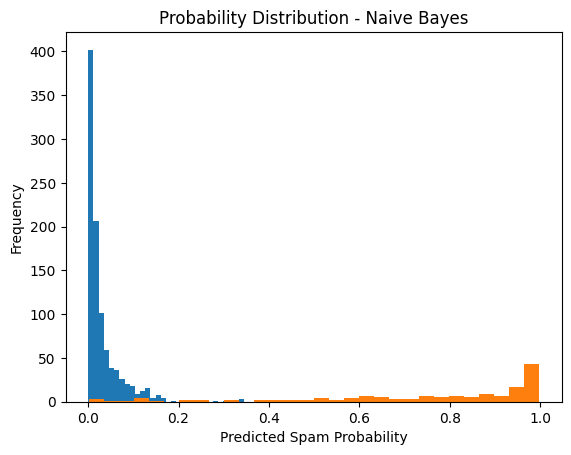

In [37]:
plt.figure()

plt.hist(y_prob_nb[y_test == 0], bins=30)
plt.hist(y_prob_nb[y_test == 1], bins=30)

plt.xlabel("Predicted Spam Probability")
plt.ylabel("Frequency")
plt.title("Probability Distribution - Naive Bayes")
plt.show()

In [38]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [39]:
from sklearn.metrics import accuracy_score

y_pred_log = log_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))

Naive Bayes Accuracy: 0.97847533632287
Logistic Regression Accuracy: 0.9695067264573991


In [40]:
y_prob_log = log_model.predict_proba(X_test_tfidf)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
auc_log = roc_auc_score(y_test, y_prob_log)

print("Logistic Regression AUC:", auc_log)

Logistic Regression AUC: 0.9890991704531245


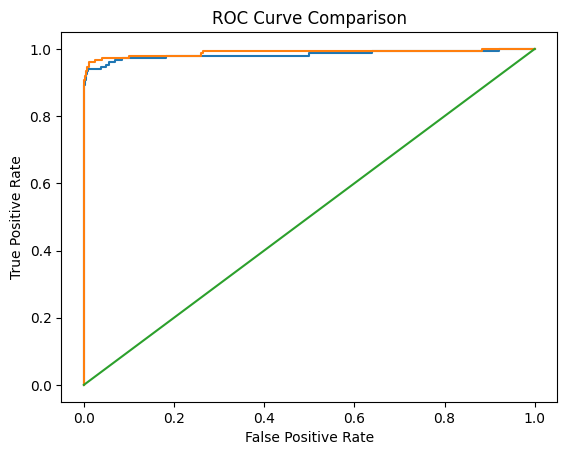

In [41]:
plt.figure()

plt.plot(fpr_nb, tpr_nb)
plt.plot(fpr_log, tpr_log)
plt.plot([0, 1], [0, 1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.show()